# Degradation Analysis

A1/AX

This notebook was written by Logan Qualls. Data for this work is sourced from the National Center for Atmospheric Research's Catchment Attributes and Meterology for Large-Sample Studies (CAMELS) dataset, and this notebook is designed to work specifically with Frederik Kratzert's NeuralHydrology (NH; https://github.com/neuralhydrology/neuralhydrology) and Grey Nearing's SACSMA-SNOW17 (SAC-SMA; https://github.com/Upstream-Tech/SACSMA-SNOW17). NH provides a flexible framework with a variety of tools specifically designed for straightforward application of Long Short-Term Memory networks to hydrological modeling. The SACSMA-SNOW17 model provides a Python interface for the SAC-SMA model.

This notebook explores overall and per-basin model predictive degradation. Here, I define degradation as relative difference between NSEs in an extreme model minus NSEs in a corresponding random model.

In [1]:
#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Import Libraries

In [2]:
#Import Python libraries
import os
import sys
import copy
import numpy as np
import pandas as pd
import pickle as pkl
from functions import *
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor

### Define Parameters

##### Experiment Parameters

First we define which extreme/random model pair we want to analyze. Here, I use the LSTM with static climate attributes trained on NLDAS forcing data on data from years extracted from the NWM date range (1995-2014).

In [3]:
#########################################################################################

#Define two model types to compare (xxx = [model1 attribute,model2 attribute])
#Can use sacsma and nh models, not nwm
model = 'nh'
inp = 'static'
forcing = 'daymet'
year = 'all'

#########################################################################################

index = 'aridity'

#########################################################################################

metric = 'nse'

metric_lims = [0,1,0,1]

#########################################################################################

##### Paths

In [4]:
#########################################################################################

#Path to working_dir (current directory)
working_dir = Path(os.getcwd())

#########################################################################################

#If you use this repository's directory structure, you not need to edit the paths below, but just in case...

#Path to NH codebase (../neuralhydrology/neuralhydrology)
nh_dir = working_dir / 'neuralhydrology' / 'neuralhydrology'

#Path to main CAMELS directory (../camels)
camels_dir = working_dir / 'camels'

#Path to CAMELS forcing directory (../basin_dataset_public_v1p2)
camels_forcing_dir = camels_dir / 'basin_dataset_public_v1p2'

#Path to CAMELS attributes, version 2 file
camels_attributes_dir  = camels_dir / 'camels_attributes_v2.0/camels_attributes_v2.0.csv'

# Path to notebook_env_saves
env_saves_dir = working_dir / 'notebook_env_saves'

#########################################################################################

**You should not have to edit anything below this cell.**

In [5]:
#Define the two types of experiments
exp_types = ['random','extreme']

### Load Source Data

In [6]:
#Initiate dictionary to hold basin_metrics dictionarities (created in notebook 3)
metrics_dict = {}

#For each experiment type...
for exp_type in exp_types:

    #Naming convention depends on model type (sacsma vs. nh vs. nwm)
    if model == 'nh':
        name = f'{model}_{inp}_{exp_type}_{forcing}_{year}'
    if model == 'sacsma':
        name = f'{model}_{exp_type}_{forcing}_{year}'

    #Manually construct a filename from model descriptors (assuming it already exists; sanity check)
    metrics_file = f'basin_metrics_{name}.pkl'

    #Open the basin_metrics file...
    with open(Path(env_saves_dir / metrics_file),'rb') as f:

        #Load it
        metric_data = pkl.load(f)

    #Save dictionary under model name
    metrics_dict[name] = metric_data

In [7]:
#Get list of model names
model_names = list(metrics_dict.keys())

#Retrieve example random and extreme model
rand_model = model_names[0]
ext_model = model_names[1]

#Retrieve random and extreme experiment names from example models
rand_exps = list(metrics_dict[rand_model].keys())
ext_exps = list(metrics_dict[ext_model].keys())
ext_exps = [x for x in ext_exps if index in x]

#List of all experiments (random and extreme)
experiments = rand_exps + ext_exps

#Retrieve list of metrics from example models and example experiments
metrics = list(metrics_dict[ext_model][ext_exps[0]].keys())

#Retrieve list of basins from exmaple model and experiment index
basins = list(metrics_dict[ext_model][ext_exps[0]][metrics[0]].index)

#List of basins in integer format
basins_int = [int(x) for x in basins]

In [8]:
#For each model...
for model in model_names:

    #Get a list of its experiments
    exps = list(metrics_dict[model].keys())

    #For every experiment...
    for exp in exps:

        #Create an index of basin ids as integers
        int_index = [int(x) for x in list(metrics_dict[model][exp].index)]

        #Reindex camels ids as integers, not strings
        metrics_dict[model][exp].index = int_index

In [9]:
#Load CAMELS attributes file; gauge_id as index (integer form)
attributes = pd.read_csv(camels_attributes_dir, sep=';', index_col='gauge_id')

#Drop columns that are not quantitative values (could potentially be included if numerically categorized)
drop_cols = ['high_prec_timing','low_prec_timing','geol_1st_class',
             'geol_2nd_class','dom_land_cover','water_frac','organic_frac']

#Drop drop_cols
attributes = attributes.drop(drop_cols, axis=1)

#Drop any row that is not a CAMELS basin
attributes = attributes.loc[basins_int]

#Ensure all attribute values in same format for correlation
attributes = attributes.astype(np.float32)

### Plot Experiment CDFs

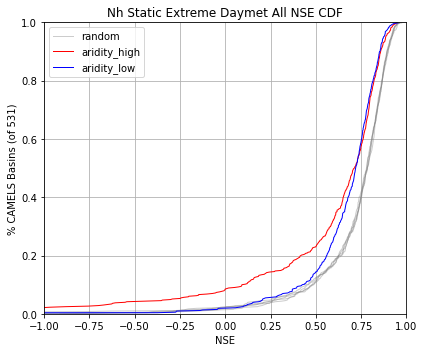

In [10]:
#Define different line styles to represent model 1 and model 2
#Set figure size
plt.figure(figsize=(6, 5))

#Counter for plotted random experiment lines
r = 0

#For every model...
for m,model in enumerate(model_names):

    #For every experiment...
    for i,exp in enumerate(experiments):

        #Try to...
        try:
            
            #Get list of basin metrics and sort according to value
            x = np.sort(metrics_dict[model][exp][metric])

            #Create range of length x with consistent interval
            y = np.arange(len(x))/(float(len(x)))
            y = y.tolist()

            #Define default line parameters
            c = 'r'
            alpha = 1
            lw = 1

            #If the index is not in the experiment name (meaning it is a random experiment)...
            if index not in exp:
                
                #Add 1 to the r counter
                r = r + 1
                
                #Set line color to grey
                c = 'grey'
                alpha=0.4
                
                #If r is equal to 1...
                if r == 1:
                    
                    #Plot line with label
                    plt.plot(x, y,c=c,lw=lw,alpha=alpha,label='random')
                    continue
                
                #If r is NOT equal to 1...
                else:
                    
                    #Plot line without label
                    plt.plot(x, y,c=c,lw=lw,alpha=alpha)
                    continue
                    
            #If we are plotting a "low" experiment...
            if 'low' in exp:

                #Set line color to blue (default is red, for "high" experiments)
                c = 'blue'

            #Plot line
            plt.plot(x, y,c=c,lw=lw,alpha=alpha,label=exp)
        
        #Otherwise, if you can't do all of that, continue to the next experiment
        except: continue

#Split model name by '_'
title = name.split('_')

#Capitalize each element in title
title = [x.capitalize() for x in title]

#Rejoin with spaces
title = ' '.join(title)

#Set title
plt.title(f'{title} {metric.upper()} CDF')

#Show grid
plt.grid()

#Show legend
plt.legend(loc=2)

#Set y-label
plt.ylabel('% CAMELS Basins (of 531)')

#Set axis limits
plt.ylim(0,1)
plt.xlim(-1,1)

#Set x-label to uppercase metric
plt.xlabel(metric.upper())

#Show plot
plt.tight_layout()

### X/Y Metric Plots

Here we plot the difference between a basin's metric in an extreme experiment versus the basin's metric in the random experiment. Each point represents a basin, and a basin in colored by its respective attribute value as detailed in the title of the subplot. With the NSE metric for example, if a point (basin) plots above the diagonal line, the model on the Y-axis made better predictions in that basin, and if the point plots below the diagonal line, the model on the X-axis made better predictions in that basin.

In [11]:
#Initiate list to hold random experiment nses
rand_list = []

#For each random experiment...
for exp in rand_exps:
    
    #Append series to rand_list
    rand_list.append(metrics_dict[rand_model][exp][metric])

#Concat rand_list to get mean NSE scores per-basin
mean_rand = np.mean(pd.concat(rand_list,axis=1),axis=1)

#Set series index to basins as integers 
mean_rand.index = basins_int

In [12]:
#Initialize dataframe to contain model's per-basin nse scores
metric_df = pd.DataFrame(index=basins_int)

#And for each experiment...
for exp in ext_exps:

    #Fill the column with basins' nse scores for that model
    metric_df[f'{exp}_nse'] = metrics_dict[ext_model][exp][metric]
    
# metric_df['random_nse'] = mean_rand
            
#Preview nse_df
metric_df.head()

aridity_high_nse aridity_low_nse
1022500         0.884104        0.858129
1031500         0.795927        0.866352
1047000         0.812534        0.801092
1052500         0.847819        0.867029
1054200         0.710859        0.547462

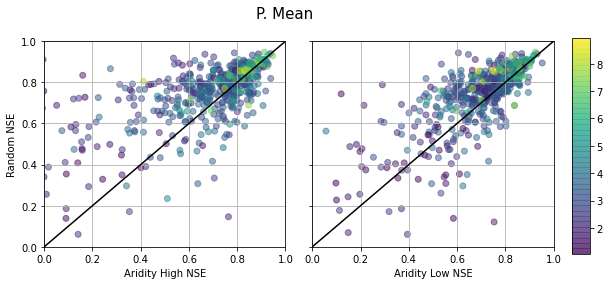

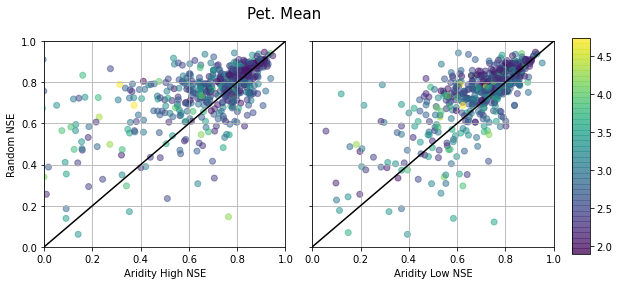

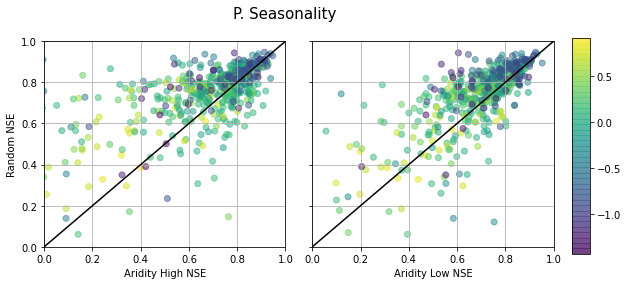

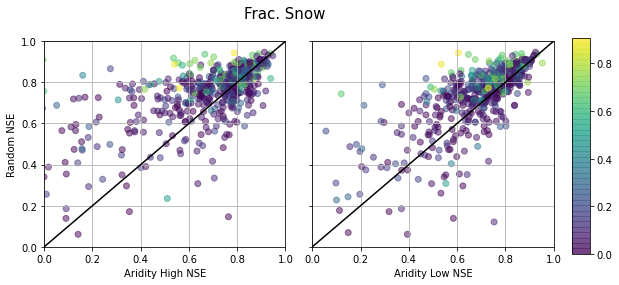

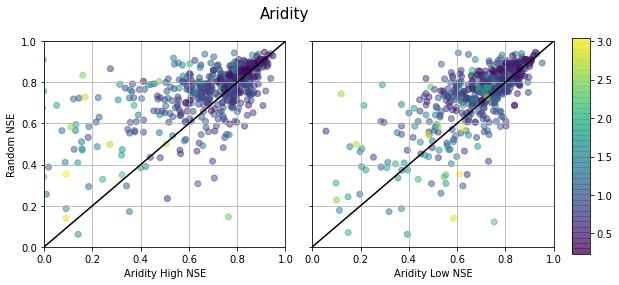

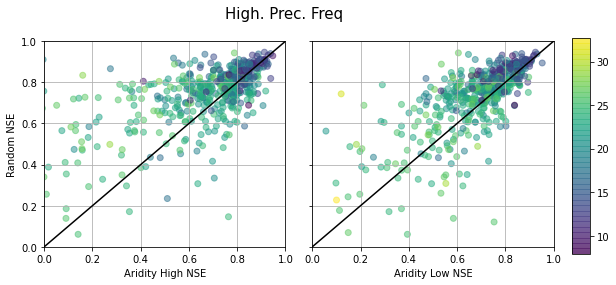

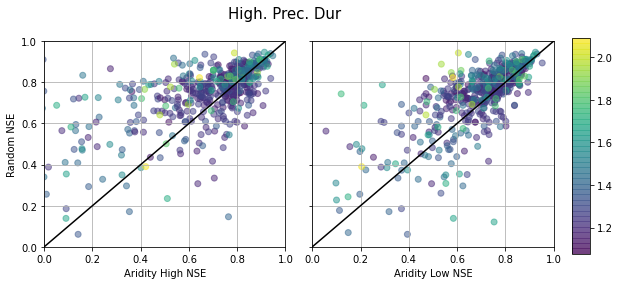

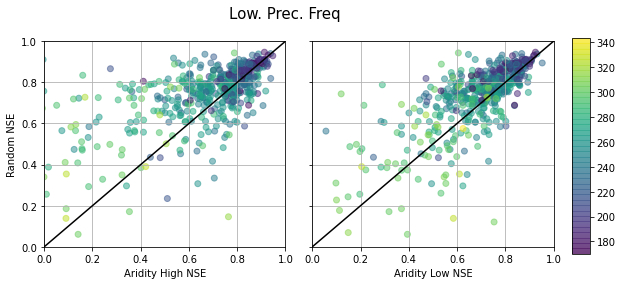

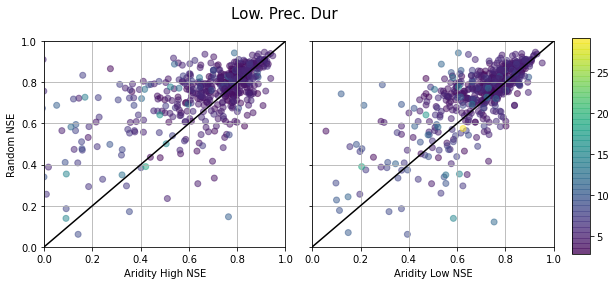

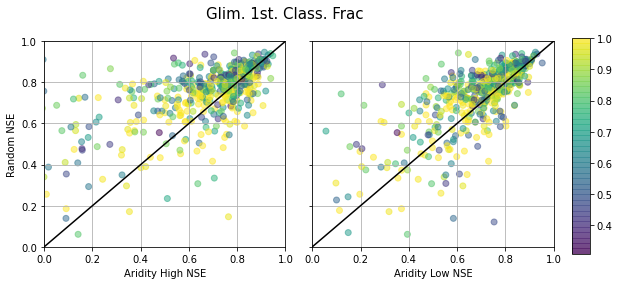

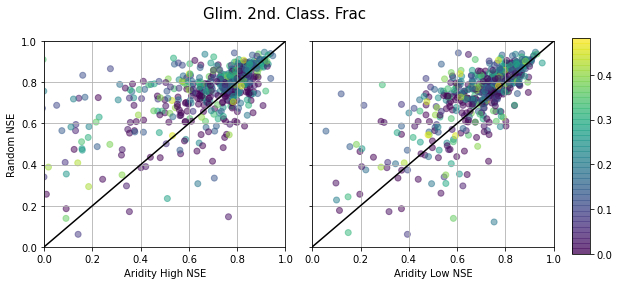

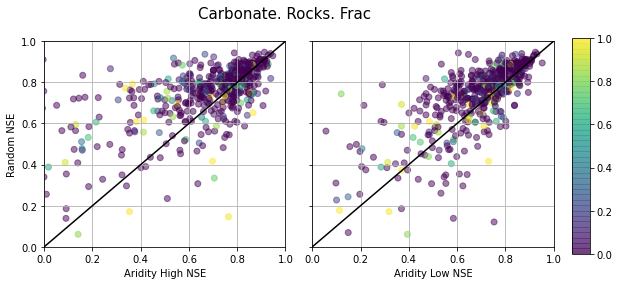

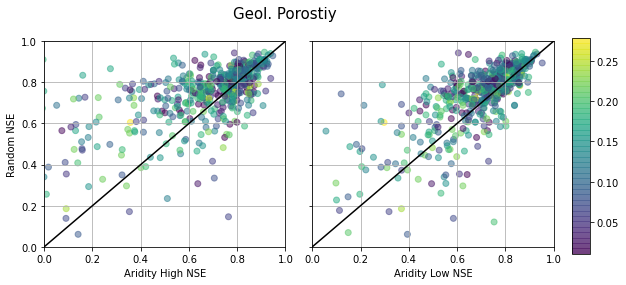

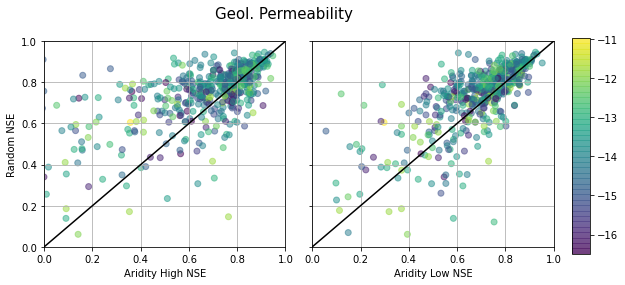

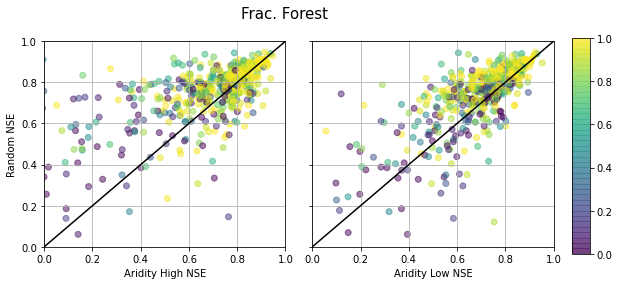

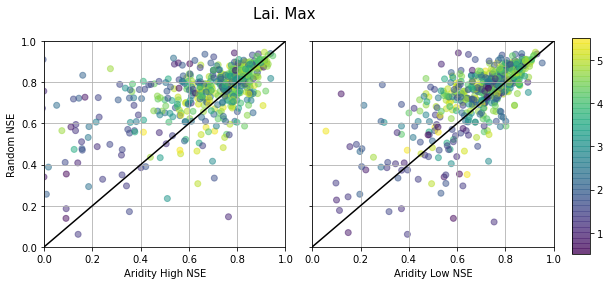

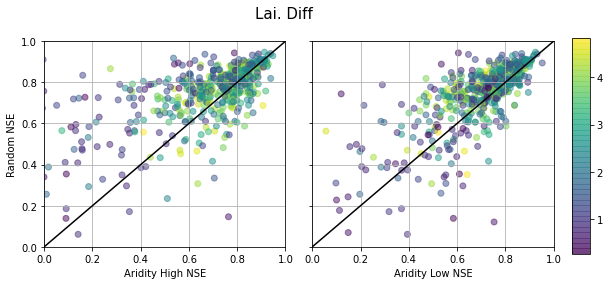

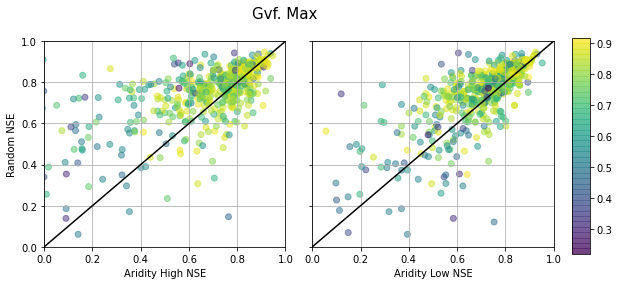

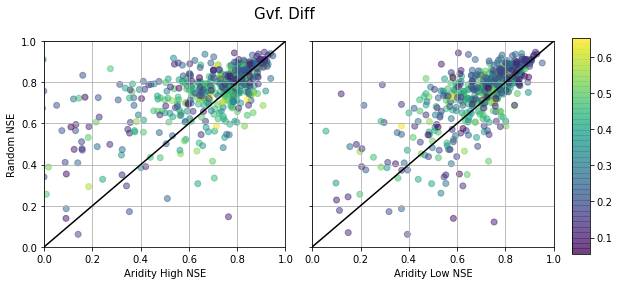

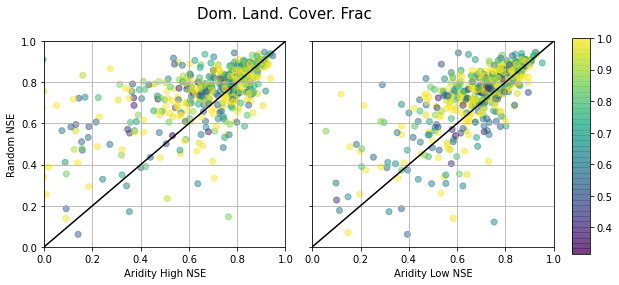

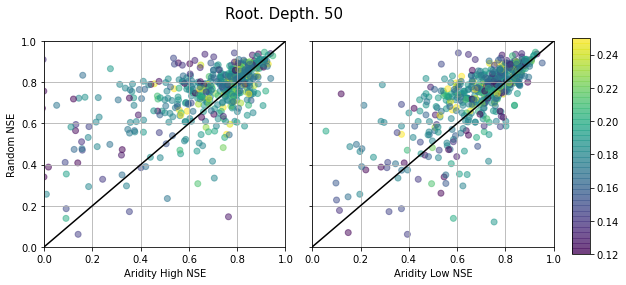

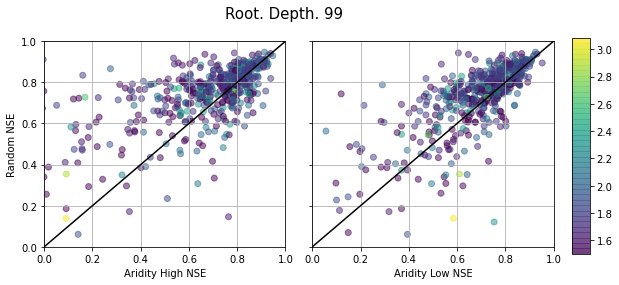

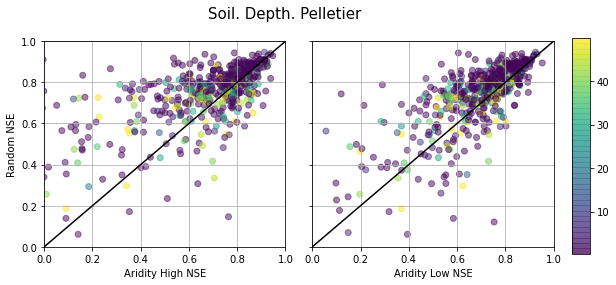

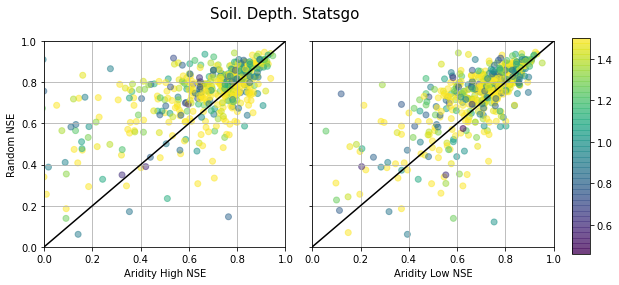

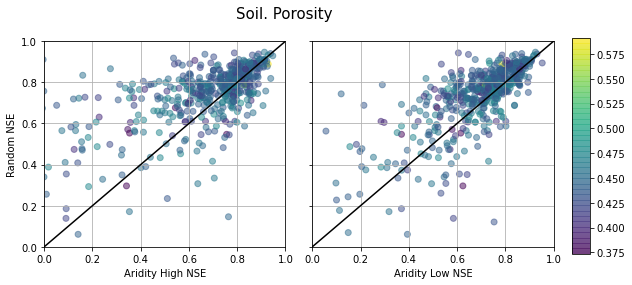

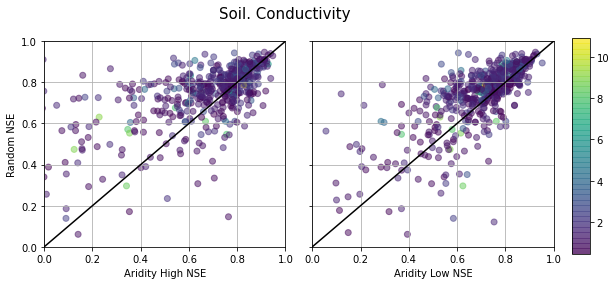

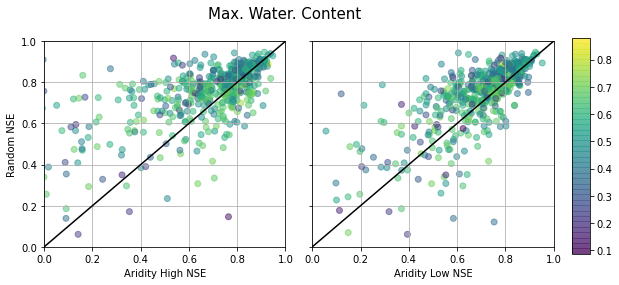

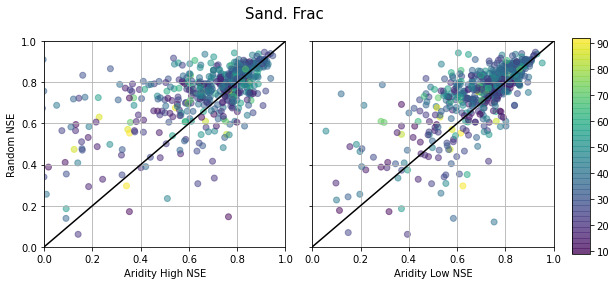

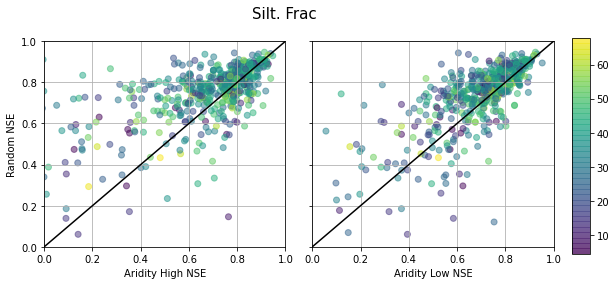

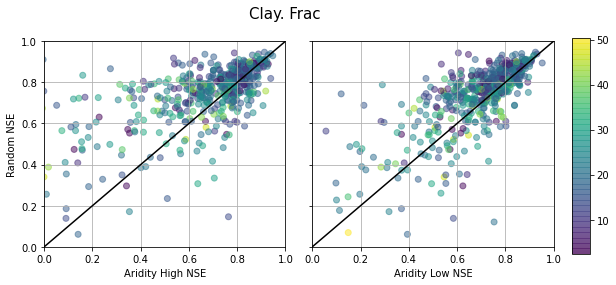

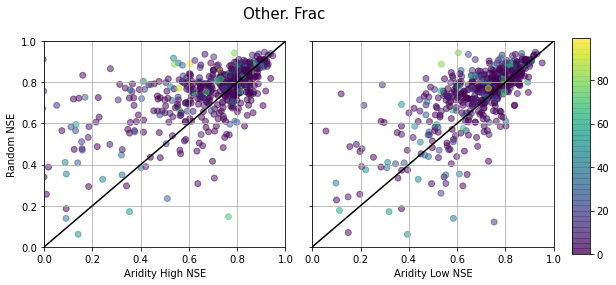

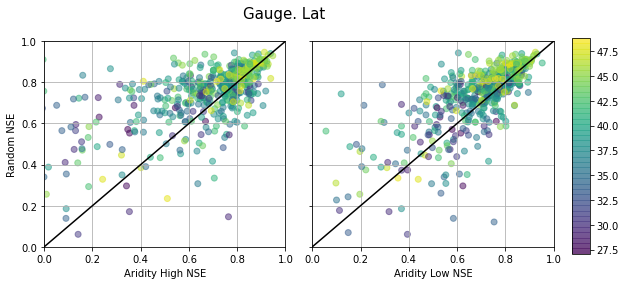

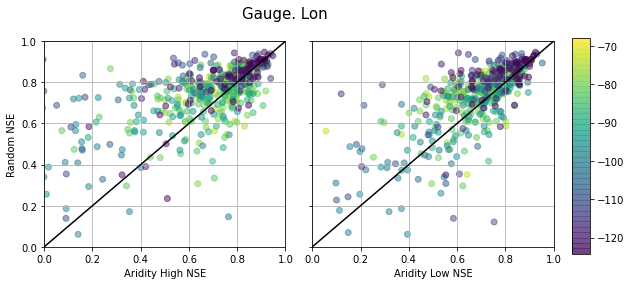

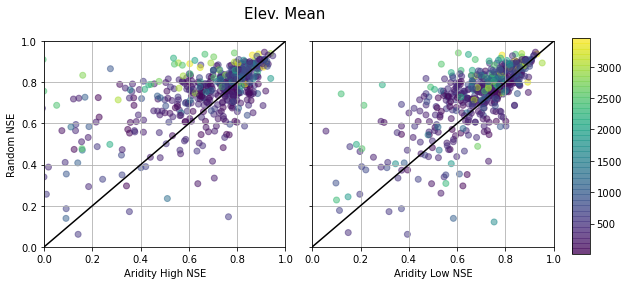

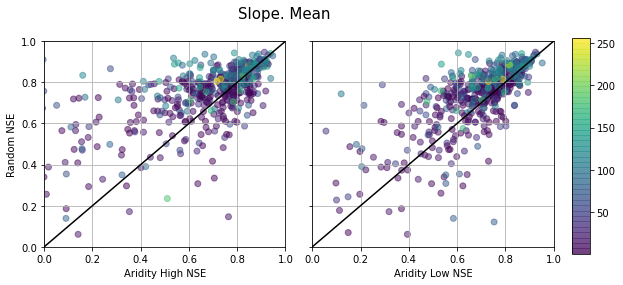

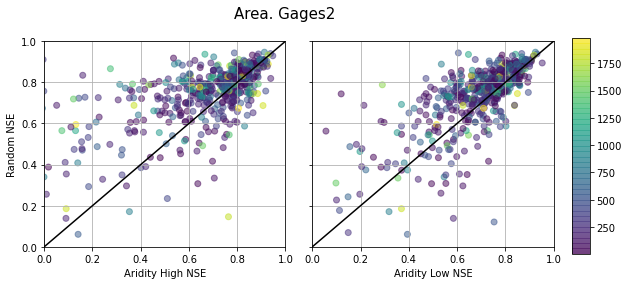

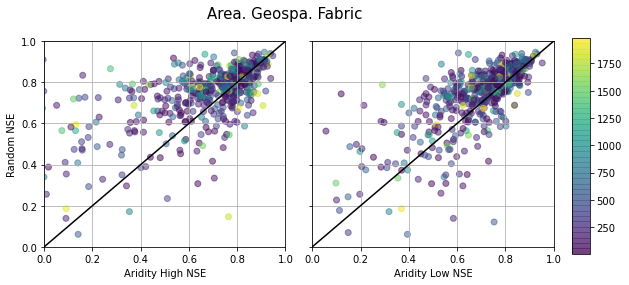

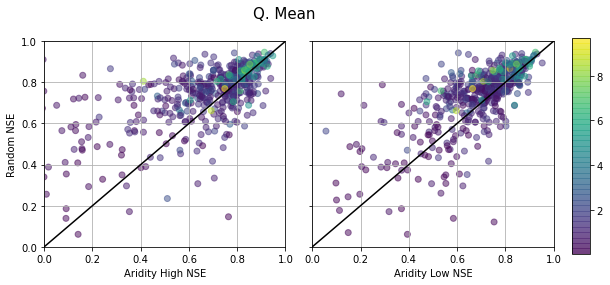

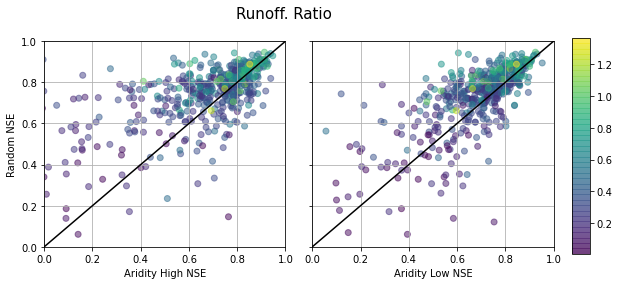

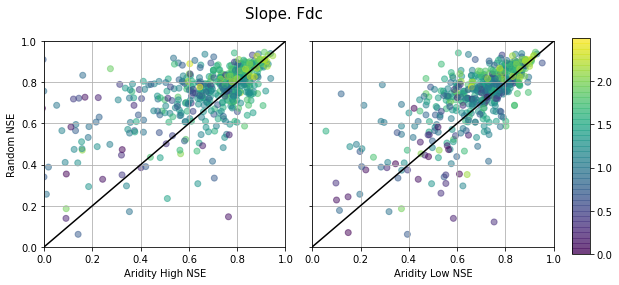

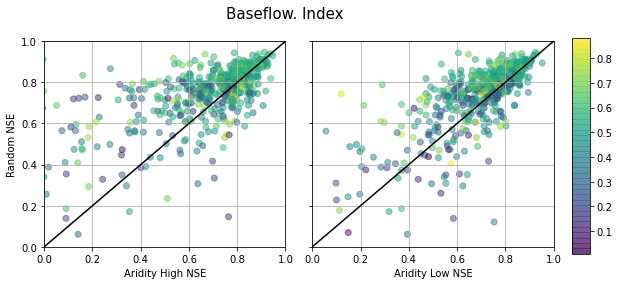

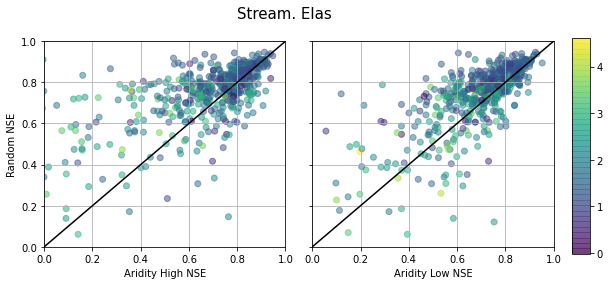

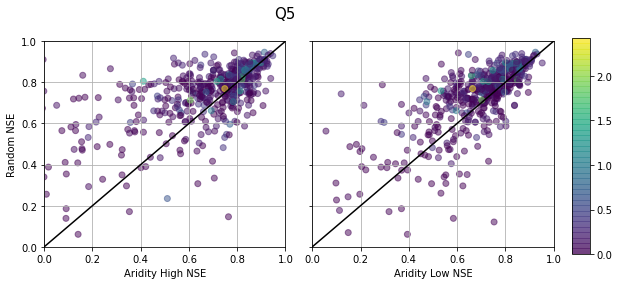

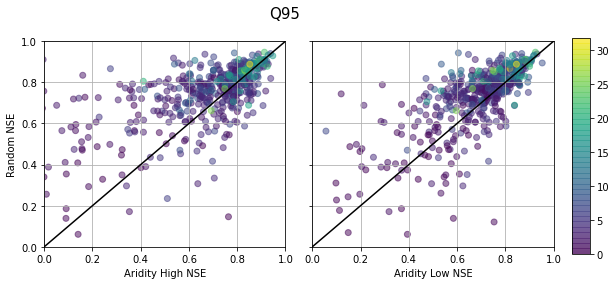

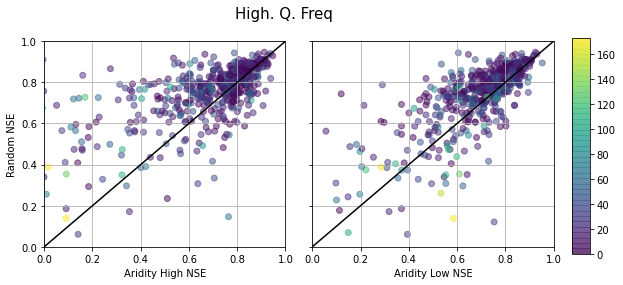

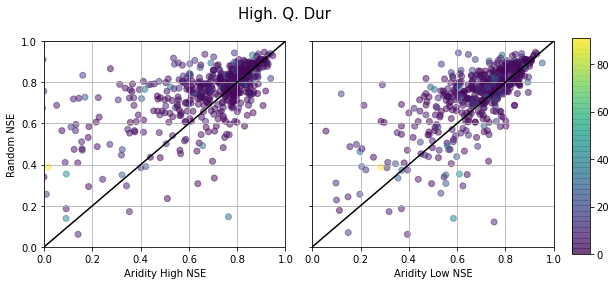

In [13]:
#Retrieve basin metrics for the random model (y-coordinate)
y = pd.DataFrame(mean_rand, index = basins_int).loc[attributes.index]

#For every column (attribute) in the CAMELS attributes dataframe...
for col in list(attributes.columns[:-4]):

    #Create a 1x2 grid of plots (one plot for each experiment)
    fig, axs = plt.subplots(1,2,figsize = (8,4))

    #And for every experiment...
    for e,exp in enumerate(ext_exps):

        #Retrieve basin metrics for extreme model (x-coordinate)
        x = pd.DataFrame(metrics_dict[ext_model][exp][metric], 
                         index = basins_int).loc[attributes.index]

        #Plot x = y line
        axs[e].plot([-1400,1],[-1400,1],c='k',label='y=x')

        #Plot X,Y (basin's metric score in each model)
        im = axs[e].scatter(x, y,
            #Color by value of given static attribute
            c=attributes[col],
            #Make a little see-through
            alpha=0.5)
        
        #Split experiment name by '_'
        title = exp.split('_')
        
        #Capitalize each element in title
        title = [x.capitalize() for x in title]
        
        #Rejoin title with spaces
        title = ' '.join(title)

        #Show grid
        axs[e].grid()
        
        #Set axes according to metric being plotted
        axs[e].axis(metric_lims)
        
        #Set sub-titles (experiment)
        axs[e].set_xlabel(f'{title} NSE')
        
        #Attribute name; split by '_'
        an = col.split('_')
        #Capitalize each element in an
        an = [a.capitalize() for a in an]
        #Rejoin an
        an = '. '.join(an)

    #Set super title (attribute)
    fig.suptitle(f'{an}', fontsize=15)
    
    #Adjust position of subplots
    fig.subplots_adjust(right=0.85)
    
    #Format colorbar
    cbar_ax = fig.add_axes([1, 0.12, 0.03, 0.75])
    
    #Show colorbar
    fig.colorbar(im, cax=cbar_ax)
    
    #Set y-label
    axs[0].set_ylabel(f'Random {metric.upper()}')

    #Hide inner axis labels
    for ax in axs.flat:
        ax.label_outer() 

    #Plot
    plt.tight_layout()

### Spatial Plots (Metric Differences)

Now we can plot the difference between a basin's metric in the extreme experiment versus the basin's metric in the random experiment spatially.

In [14]:
#Initiate lists of basin latitudes and longitudes
plot_lats = []
plot_lons = []

#For every basin...
for basin in basins:
    
    #Append lat/long from attribute columns to lists
    plot_lats.append(attributes.loc[int(basin),'gauge_lat'])
    plot_lons.append(attributes.loc[int(basin),'gauge_lon'])

#Make list arrays
plot_lats = np.array(plot_lats)
plot_lons = np.array(plot_lons)

In [15]:
#Create dataframe to store metric differences
diff_df = pd.DataFrame(index=basins_int)

#For every extreme experiment...
for exp in ext_exps:

    #Create column containing the delta metric value (metric in extreme model - metric in random model)
    diff_df[f'{exp}_delta_{metric}'] = (metrics_dict[ext_model][exp][metric] - mean_rand)

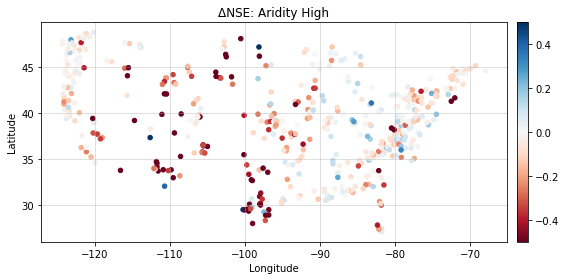

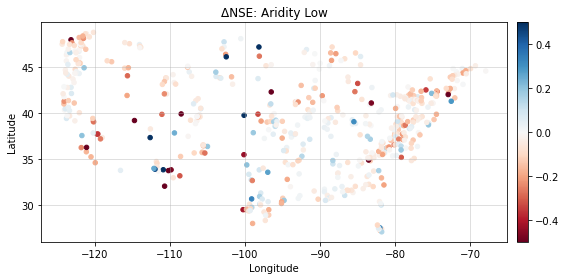

In [16]:
#For every experiment...
for e,exp in enumerate(ext_exps):
    
    #Create figure
    plt.figure(figsize=(8,4))

    #Initiate throwaway list of metrics
    m_list = []

    #For every basin...
    for basin in basins_int:
        
        #Get metric data for a basin for that experiment
        m_data = diff_df[f'{exp}_delta_{metric}'][basin]

        #Append that data to m_list
        m_list.append(m_data)

    #Plot scatter plot of basin locations and color based on their metric value
    im = plt.scatter(plot_lons, plot_lats,
        c=np.array(m_list),
        s=20,
        vmin=-0.5,vmax=0.5,
        cmap='RdBu')
    
    #Split experiment name by '_'
    title = exp.split('_')
    
    #Capitalize each element in title
    title = [x.capitalize() for x in title]
    
    #Rejoin with spaces
    title = ' '.join(title)

    #Set title and labels
    plt.title(f'Δ{metric.upper()}: {title}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    #Show grid
    plt.grid(True, alpha=0.5)
    
    #Plot colorbar
    plt.colorbar(im,fraction=0.046, pad=0.02)
    
    #Plot
    plt.tight_layout()

### Linear Correlation Analysis

To perform a linear correlation analysis, there can be no infinity values in the datasets. In this example, basin 8202700 has an NSE score of -inf, so I manually exclude it to proceed with the analysis. This must be done for both the diff_df and attributes copies because each series must be the same size for the correlation analysis.

In [17]:
#Make copy of diff_df
all_df = diff_df.copy(deep=True)
#Join with metric_df
all_df = all_df.join(metric_df)
#Drop basin with -inf value
all_df = all_df.drop(8202700,axis=0)
#Make copy of attributes
attributes_copy = attributes.copy(deep=True)
#Drop basin with -inf value
attributes_copy = attributes_copy.drop(8202700,axis=0)

In [18]:
#Define a function to mask nans; note: this does not account for infinities!
def _mask_nans(sim, obs):
    #If the NSE is a NAN in either instance, remove it
    mask = np.logical_and(~np.isnan(obs), ~np.isnan(sim))
    return mask

In [19]:
#Initialize correlation dataframe
metric_attribute_corrs = pd.DataFrame(index=attributes_copy.columns, columns=all_df.columns) 

#For every "metric"...
for metric in all_df.columns:
    
    #And for every attribute...
    for attribute in attributes_copy.columns:
        
        #Define variables and apply mask
        att = attributes_copy[attribute].astype(float)
        met = all_df[metric].astype(float)
        mask = _mask_nans(att, met)
        
        #Calculate the correlation coefficient between that metric and attribute
        metric_attribute_corrs[metric][attribute] = np.corrcoef(att[mask], met[mask])[0,1]
        
#Preview metric_attribute_corrs
metric_attribute_corrs.head()

aridity_high_delta_nse aridity_low_delta_nse aridity_high_nse  \
p_mean                      0.175706              0.036721         0.240269   
pet_mean                   -0.149719             -0.042859        -0.187292   
p_seasonality               0.002621              0.014783        -0.056499   
frac_snow                  -0.090473             -0.036691        -0.045577   
aridity                    -0.269664              -0.12096        -0.351996   

              aridity_low_nse  
p_mean               0.156547  
pet_mean            -0.113872  
p_seasonality       -0.088194  
frac_snow             0.03779  
aridity             -0.270097

If the resulting dataframe returns a column of NANs, you likely have an infinity value somewhere.

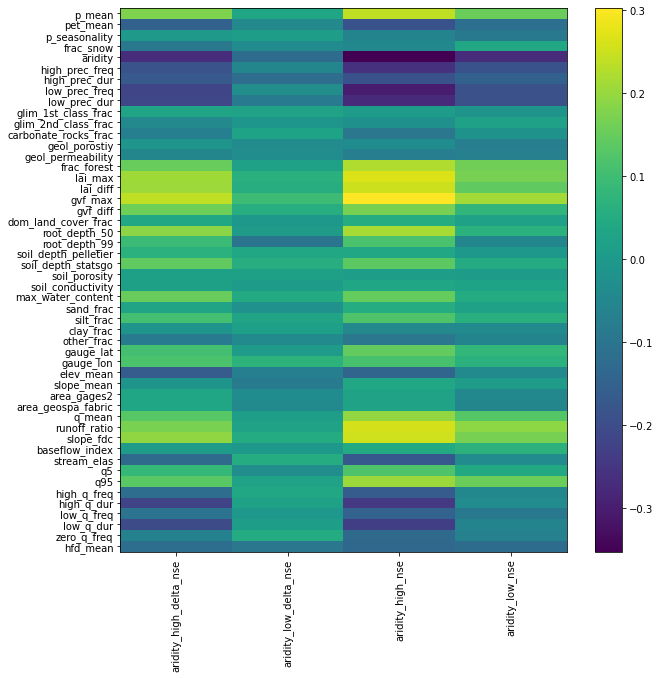

In [20]:
#Create plot
fig = plt.figure(figsize=(10, len(attributes_copy.columns)/5))

#Plot correlations
im = plt.imshow(metric_attribute_corrs.astype(float), aspect='auto')

#Set x-ticks to "metrics"
plt.xticks(range(len(metric_attribute_corrs.columns)), labels=metric_attribute_corrs.columns, rotation=90)

#Set y-ticks to attributes
plt.yticks(range(len(attributes_copy.columns)), labels=attributes_copy.columns)

#Draw colorbar
fig.colorbar(im)

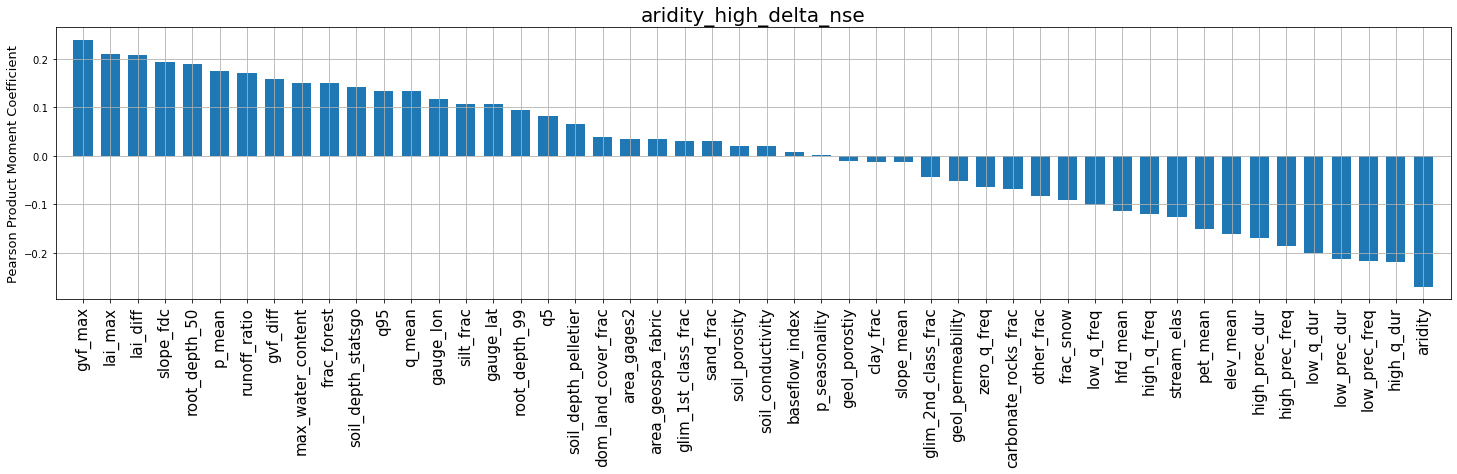

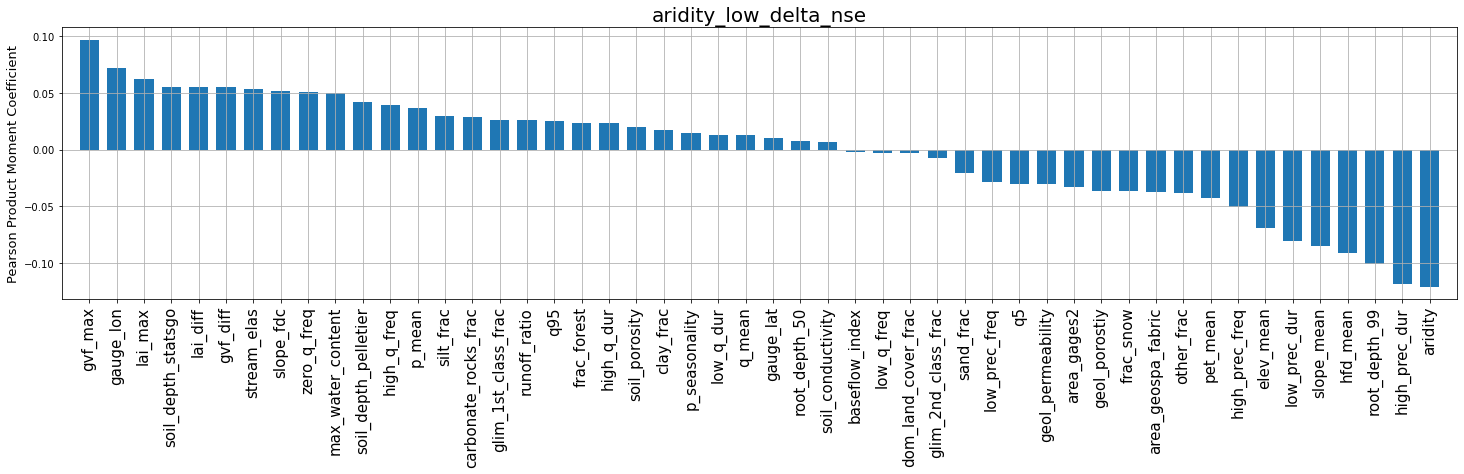

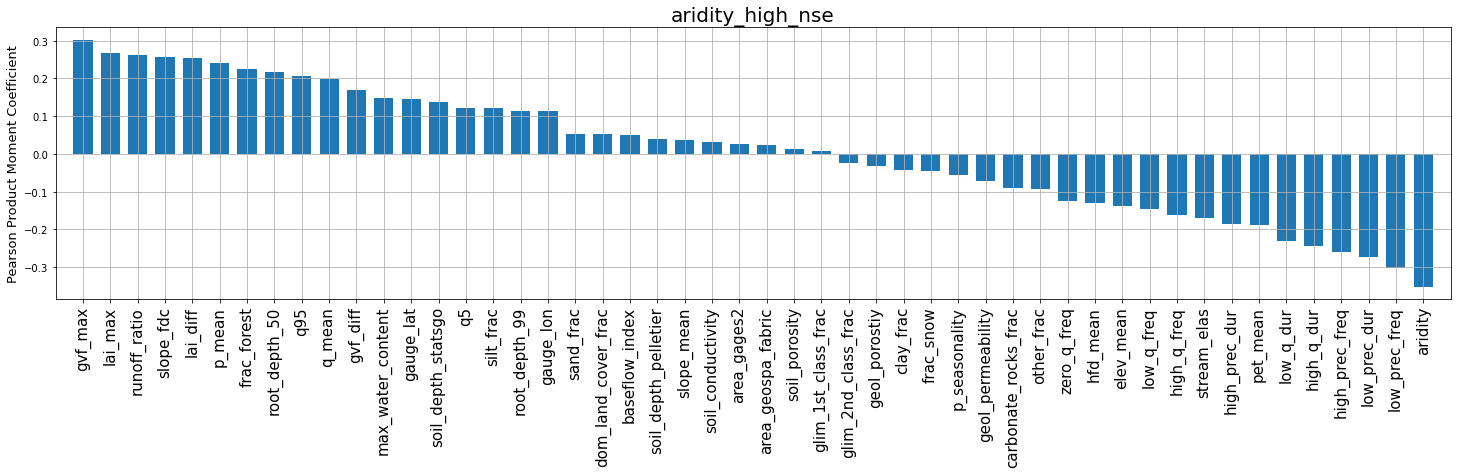

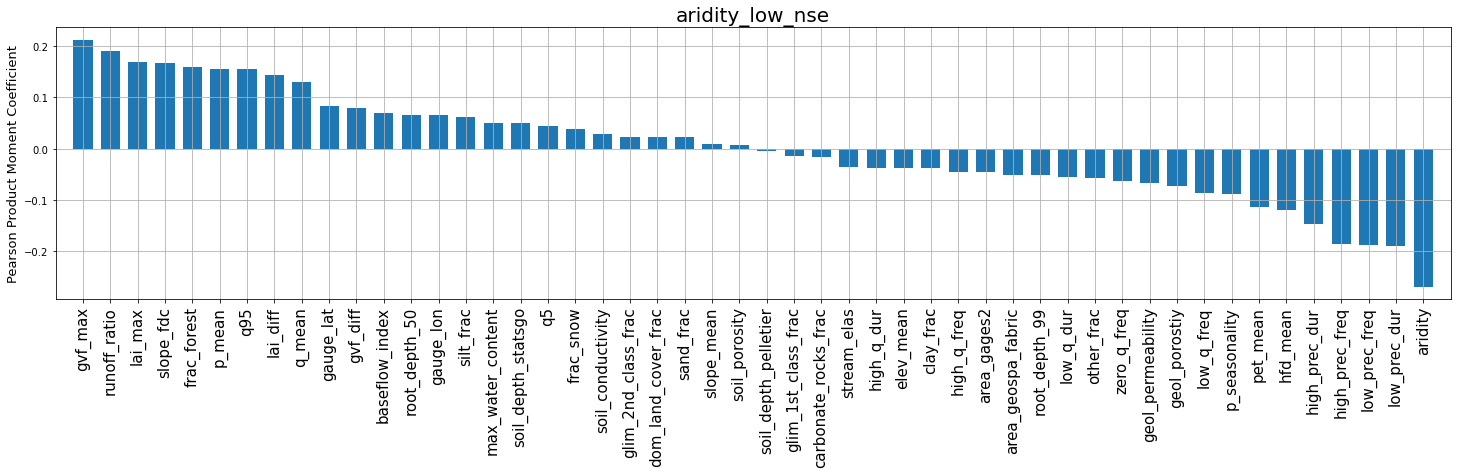

In [25]:
#For each correlation...
for corr in metric_attribute_corrs.columns:

    #Create figure
    fig = plt.figure(figsize=(25, 5))
    
    #Plot bar plot
    plt.bar(attributes.columns, metric_attribute_corrs[corr].sort_values(ascending=False),width=0.7)
    
    #Set x-ticks
    plt.xticks(range(len(attributes.columns)),
        labels=metric_attribute_corrs[corr].sort_values(ascending=False).index, rotation=90,fontsize=15)

    #Show grid
    plt.grid()
    
    #Set axis limits
    plt.xlim(0-1,len(attributes.columns))
    
    #Set title and labels
    plt.title(f'{corr}',fontsize=20)
    plt.ylabel('Pearson Product Moment Coefficient',fontsize=13)
    
    #Show figure
    plt.show()

### Nonlinear Correlation Analysis

In [26]:
#Define number of kfold splits, trees
n_kfold = 10
n_trees = 200

#Define attributes to drop from dfs
drop_attributes = ['gauge_lat', 'gauge_lon']

In [31]:
def _make_predictors(metric):
  predictand = all_df[metric].copy()
  predictors = attributes.copy()
  joined = pd.concat([predictand, predictors], axis=1).dropna(axis=0)
  predictand = joined[metric]
  predictors = joined.drop(metric, axis=1)

  predictors.drop(drop_attributes, axis=1, inplace=True)
  print(f'There are {predictors.shape[1]} predictors.')
  print(f'There are {predictors.shape[0]} samples.')

  return predictors, predictand

def _train_kfold(predictors, predictand):
  # Initialize storage.
  basins = list(predictand.index)
  y_hat = pd.Series(index=basins)

  # Create a separate split for each ensemble member.
  kf = model_selection.KFold(n_splits=n_kfold, random_state=None, shuffle=True)

  # Train and test the model.
  for kfold, (train_index, test_index) in enumerate(kf.split(basins)):
    print(f'Training fold # {kfold}')

    # Train/test split.
    train_basins = [basins[idx] for idx in train_index]
    test_basins = [basins[idx] for idx in test_index]
    train_y = predictand.loc[train_basins]#.dropna()
    train_x = predictors.loc[train_y.index]
    test_x = predictors.loc[test_basins]

    # RF model with 1000 trees.
    rf = RandomForestRegressor(n_estimators=n_trees, random_state=42)
    rf.fit(train_x, train_y)

    # Predictions.
    y_hat.loc[test_basins] = rf.predict(test_x)

  return y_hat

def _score_regression(predictand, y_hat, metric):
  # Skill in predicting where we will do well.
  y_hat.name = f'Predicted {metric}'
  rf_results = pd.concat([predictand.astype(float), y_hat.astype(float)], axis=1).dropna()
  r2 = np.corrcoef(rf_results.values.transpose())[0,1]
  print(f'The r2 value for the kfold predictions is {r2}.')

  plt.scatter(rf_results[metric], rf_results[f'Predicted {metric}'])
  plt.plot((-100,1), (-100,1), 'k--')
  plt.grid()
  plt.axis([-1,1,-1,1])
  plt.xlabel(f'True Model Score: {metric}')
  plt.ylabel(f'Predicted Model Score: {metric}')
  plt.title(metric)

def _plot_feature_importances(predictors, predictand):
  # Train a predictor with all of the data.
  rf = RandomForestRegressor(n_estimators=n_trees, random_state=42)
  rf.fit(predictors, predictand)

  # Extract importances.
  importance_stds = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
  importances = pd.Series(index=predictors.columns, data=rf.feature_importances_)

  # Plot.
  fig, ax = plt.subplots(figsize=(30,7))
  importances.plot.bar(yerr=importance_stds, ax=ax)
  ax.set_title("Feature importances using MDI")
  ax.set_ylabel("Mean decrease in impurity")

def nonlinear_correlation_analysis(metric):
  predictors, predictand = _make_predictors(metric)
  y_hat = _train_kfold(predictors, predictand)
  _score_regression(predictand, y_hat, metric)
  _plot_feature_importances(predictors, predictand)
  return y_hat

There are 48 predictors.
There are 514 samples.
Training fold # 0
Training fold # 1
Training fold # 2
Training fold # 3
Training fold # 4
Training fold # 5
Training fold # 6
Training fold # 7
Training fold # 8
Training fold # 9
The r2 value for the kfold predictions is 0.28048816085720935.


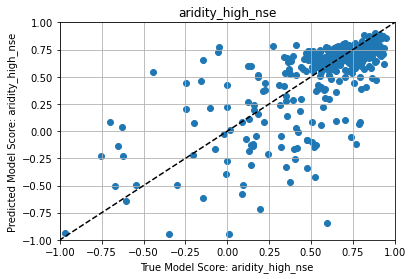

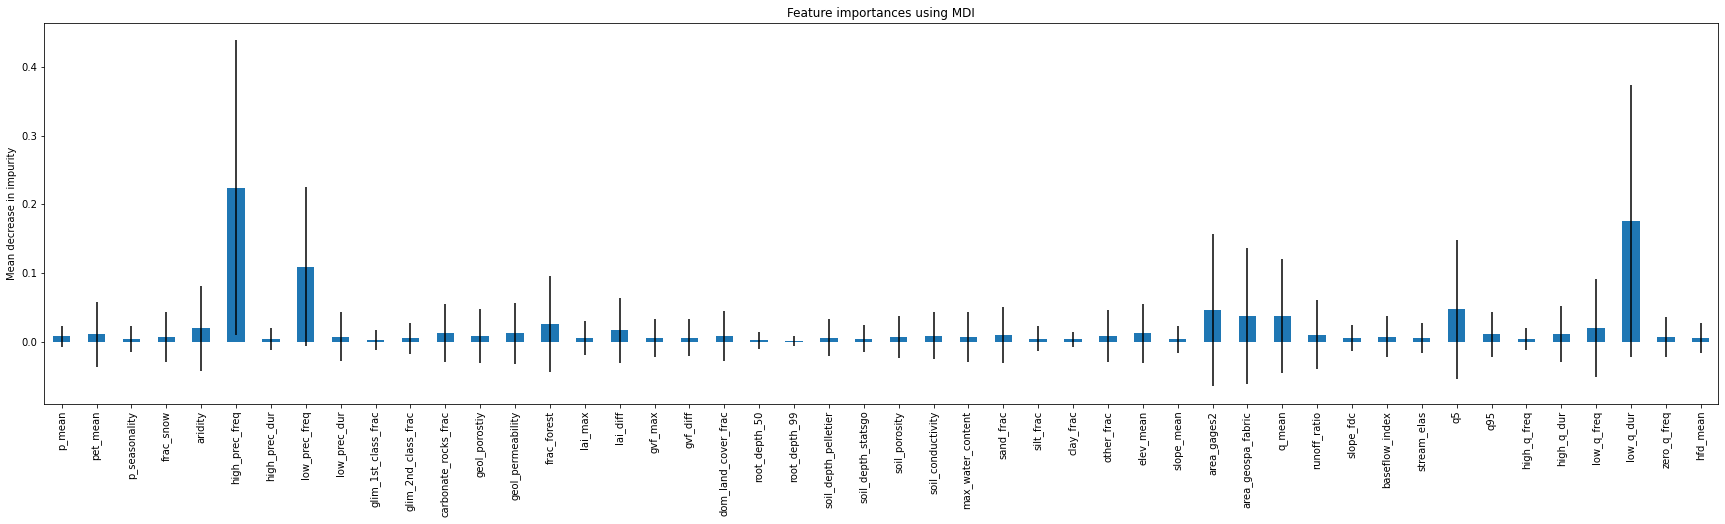

In [32]:
#Set experiment to analyze
exp = 'aridity_high_nse'

#Make predictions
y_hat = nonlinear_correlation_analysis(exp)

#Concat with latitude and longitude attributes
nse_predictions = pd.concat([metric_df[exp], y_hat, attributes[['gauge_lat', 'gauge_lon']]], axis=1)